In [ ]:
# 1A

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
crsp = pd.read_csv("crsp_1926_2020.zip")

# Convert column names to lowercase
crsp.columns = crsp.columns.str.lower()

# Get rid of rows with any non-numeric values
numeric_cols = [c for c in crsp.columns if c not in ['date']]
crsp[numeric_cols] = crsp[numeric_cols].apply(pd.to_numeric, errors='coerce')
crsp = crsp.dropna(subset=numeric_cols).reset_index(drop=True)

# Only include stocks that are ordinary/common shares (shrcd = 10 or 11)
crsp = crsp[crsp['shrcd'].isin([10, 11])]

# Only include stocks listed on the NYSE, AMEX, or NASDAQ (exchcd = 1, 2, 3)
crsp = crsp[crsp['exchcd'].isin([1, 2, 3])]

# Set negative prices to NA (prc < 0)
crsp.loc[crsp['prc'] < 0, 'prc'] = pd.NA

# Show the cleaned up data
crsp

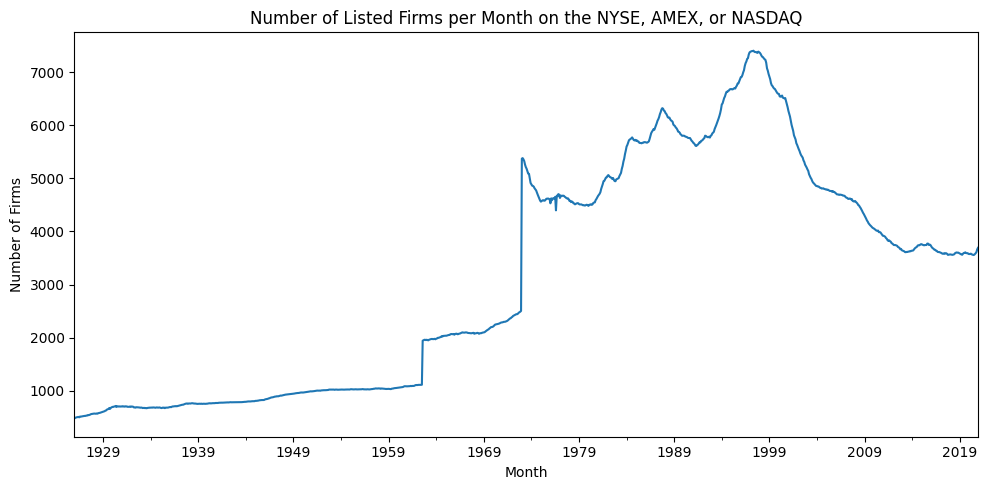

In [23]:
# 1B

# Convert date to datetime and extract month
crsp['date'] = pd.to_datetime(crsp['date'], errors='coerce')
crsp['date'] = crsp['date'].dt.to_period('M')

# Count number of unique firms (permno) per month
monthly_firm_counts = crsp.groupby('date')['permno'].nunique()

# Plot
monthly_firm_counts.plot(
    title="Number of Listed Firms per Month on the NYSE, AMEX, or NASDAQ", 
                         figsize=(10, 5))
plt.xlabel("Month")
plt.ylabel("Number of Firms")
plt.tight_layout()
plt.show()

In [29]:
# 2A

import numpy as np

# 1. Load and clean CRSP data
crsp = pd.read_csv('crsp_1926_2020.csv', parse_dates=['date'])
crsp = crsp[
    crsp['SHRCD'].isin([10, 11]) &               # only common shares
    crsp['EXCHCD'].isin([1, 2, 3])               # only NYSE, AMEX, NASDAQ
].copy()
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')
crsp.loc[crsp['PRC'] < 0, 'PRC'] = np.nan       # negative prices → NA
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['ME']  = crsp['PRC'].abs() * crsp['SHROUT'] # market cap

crsp

# 2. Assign size decile (1=smallest, 10=largest) each month
crsp['size_decile'] = (
    crsp
    .dropna(subset=['ME'])
    .groupby('date')['ME']
    .transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
)

# 3. Compute portfolio returns by decile
ew = (
    crsp
    .dropna(subset=['size_decile'])
    .groupby(['date', 'size_decile'])['RET']
    .mean()
    .unstack('size_decile')
    .sort_index(axis=1)
)
vw = (
    crsp
    .dropna(subset=['size_decile'])
    .groupby(['date', 'size_decile'])
    .apply(lambda x: (x['RET'] * x['ME']).sum() / x['ME'].sum())
    .unstack('size_decile')
    .sort_index(axis=1)
)
ew.columns = [f'Decile_{i}' for i in ew.columns]
vw.columns = [f'Decile_{i}' for i in vw.columns]

# ew and vw now hold monthly return series for Decile_1 … Decile_10


/var/folders/h2/hsh48ttn3ngf0zf409hw9b0h0000gn/T/ipykernel_12923/2085972252.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['RET'] * x['ME']).sum() / x['ME'].sum())


In [25]:
# 2B

# Compute mean returns across time
mean_ew = ew.mean()
mean_vw = vw.mean()

print("Equal‐weighted decile means:")
print(mean_ew)
print("Monotonic decreasing? ", mean_ew.is_monotonic_decreasing)

print("\nValue‐weighted decile means:")
print(mean_vw)
print("Monotonic decreasing? ", mean_vw.is_monotonic_decreasing)


Equal‐weighted decile means:
Decile_1.0    -0.004884
Decile_2.0     0.011973
Decile_3.0     0.013357
Decile_4.0     0.015108
Decile_5.0     0.017202
Decile_6.0     0.017586
Decile_7.0     0.017644
Decile_8.0     0.017627
Decile_9.0     0.016295
Decile_10.0    0.014873
dtype: float64
Monotonic decreasing?  False

Value‐weighted decile means:
Decile_1.0     0.001179
Decile_2.0     0.012085
Decile_3.0     0.013270
Decile_4.0     0.015137
Decile_5.0     0.017110
Decile_6.0     0.017407
Decile_7.0     0.017474
Decile_8.0     0.017380
Decile_9.0     0.016047
Decile_10.0    0.014364
dtype: float64
Monotonic decreasing?  False


In [26]:
# 2C: Small‑minus‑Big (after 2A & 2B have been executed)

# 1. Inspect decile columns
print("EW decile columns:", ew.columns.tolist())
print("VW decile columns:", vw.columns.tolist())

# 2. Pick the first and last column dynamically
small_ew, big_ew = ew.columns[0], ew.columns[-1]
small_vw, big_vw = vw.columns[0], vw.columns[-1]

# 3. Compute SMB
smb_ew = ew[small_ew] - ew[big_ew]
smb_vw = vw[small_vw] - vw[big_vw]

# 4. Performance metrics
def perf(s):
    mu, sigma = s.mean(), s.std()
    return pd.Series({'Mean': mu, 'Volatility': sigma, 'Sharpe': mu/sigma})

print(f"\nSMB (EW) = {small_ew} – {big_ew}")
print(perf(smb_ew))

print(f"\nSMB (VW) = {small_vw} – {big_vw}")
print(perf(smb_vw))


EW decile columns: ['Decile_1.0', 'Decile_2.0', 'Decile_3.0', 'Decile_4.0', 'Decile_5.0', 'Decile_6.0', 'Decile_7.0', 'Decile_8.0', 'Decile_9.0', 'Decile_10.0']
VW decile columns: ['Decile_1.0', 'Decile_2.0', 'Decile_3.0', 'Decile_4.0', 'Decile_5.0', 'Decile_6.0', 'Decile_7.0', 'Decile_8.0', 'Decile_9.0', 'Decile_10.0']

SMB (EW) = Decile_1.0 – Decile_10.0
Mean         -0.019758
Volatility    0.088860
Sharpe       -0.222348
dtype: float64

SMB (VW) = Decile_1.0 – Decile_10.0
Mean         -0.013185
Volatility    0.085307
Sharpe       -0.154564
dtype: float64


In [27]:
# 2D

import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 1. Load & clean Fama–French 3 factors
ff3_raw = pd.read_csv(
    'F-F_Research_Data_Factors.CSV',
    skiprows=4,
    names=['Date','Mkt-RF','SMB','HML','RF'],
    index_col='Date'
)
# parse YYYYMM → datetime, drop non-date rows
parsed = pd.to_datetime(ff3_raw.index.astype(str), format='%Y%m', errors='coerce')
ff3 = ff3_raw.loc[parsed.notna()].copy()
ff3.index = parsed[parsed.notna()] + MonthEnd(0)
ff3 = ff3.astype(float) / 100

# 2. Build regression DataFrame: SMB excess returns + factors
reg = (
    pd.DataFrame({
        'excess_EW': smb_ew - ff3['RF'],
        'excess_VW': smb_vw - ff3['RF']
    })
    .join(ff3, how='inner')
    .dropna()
)

# 3. Define regressors
X_capm = sm.add_constant(reg['Mkt-RF'])
X_ff3  = sm.add_constant(reg[['Mkt-RF','SMB','HML']])

# 4. Estimate models
capm_ew = sm.OLS(reg['excess_EW'], X_capm).fit()
ff3_ew  = sm.OLS(reg['excess_EW'], X_ff3).fit()
capm_vw = sm.OLS(reg['excess_VW'], X_capm).fit()
ff3_vw  = sm.OLS(reg['excess_VW'], X_ff3).fit()

# 5. Print alphas and t‑stats
print(f"CAPM (EW SMB): alpha = {capm_ew.params['const']:.5f}, t‑stat = {capm_ew.tvalues['const']:.2f}")
print(f"FF3  (EW SMB): alpha = {ff3_ew.params['const']:.5f}, t‑stat = {ff3_ew.tvalues['const']:.2f}")
print(f"CAPM (VW SMB): alpha = {capm_vw.params['const']:.5f}, t‑stat = {capm_vw.tvalues['const']:.2f}")
print(f"FF3  (VW SMB): alpha = {ff3_vw.params['const']:.5f}, t‑stat = {ff3_vw.tvalues['const']:.2f}")


CAPM (EW SMB): alpha = -0.02675, t‑stat = -8.80
FF3  (EW SMB): alpha = -0.02989, t‑stat = -14.31
CAPM (VW SMB): alpha = -0.02051, t‑stat = -7.16
FF3  (VW SMB): alpha = -0.02361, t‑stat = -13.14


In [28]:
# 2E

# 1. Build SMB DataFrame from previously computed series
smb = pd.DataFrame({
    'SMB_EW': smb_ew,
    'SMB_VW': smb_vw
})

# 2. Performance helper
def perf(series):
    m = series.mean()
    s = series.std()
    return pd.Series({'Mean': m, 'Volatility': s, 'Sharpe': m/s})

def print_metrics(label, series):
    pm = perf(series)
    print(f"{label} → Mean: {pm['Mean']:.4f}, Vol: {pm['Volatility']:.4f}, Sharpe: {pm['Sharpe']:.2f}")

# 3. Define time periods
periods = {
    'Full Sample': smb.index,
    'Post‑FF92 (>=1992‑07‑01)': smb.index >= pd.to_datetime('1992-07-01'),
    'Post‑DotCom (>=2002‑01‑01)': smb.index >= pd.to_datetime('2002-01-01'),
}

# 4. Loop through each period and display metrics
for name, mask in periods.items():
    print(f"\n--- {name} ---")
    subset = smb.loc[mask]
    print_metrics('SMB_EW', subset['SMB_EW'])
    print_metrics('SMB_VW', subset['SMB_VW'])



--- Full Sample ---
SMB_EW → Mean: -0.0198, Vol: 0.0889, Sharpe: -0.22
SMB_VW → Mean: -0.0132, Vol: 0.0853, Sharpe: -0.15

--- Post‑FF92 (>=1992‑07‑01) ---
SMB_EW → Mean: -0.0399, Vol: 0.0658, Sharpe: -0.61
SMB_VW → Mean: -0.0278, Vol: 0.0636, Sharpe: -0.44

--- Post‑DotCom (>=2002‑01‑01) ---
SMB_EW → Mean: -0.0350, Vol: 0.0551, Sharpe: -0.63
SMB_VW → Mean: -0.0237, Vol: 0.0564, Sharpe: -0.42
